# EECS731 - Project 6: Anomaly Detection

Using the Amazon Twitter dataset from [here on Kaggle](https://www.kaggle.com/boltzmannbrain/nab) I wanted to detect anomalies in the number of tweets talking about Amazon. This could imply some large news event or something similar. In all the graphs here, red dots are anomalous observations and blue are considered not anomalies.

In [1]:
%matplotlib inline

import numpy as np
import pandas

## Loading data and inital cleanning

The main thing here is we need to convert the timestamp from a string into a datetime so we can work with it in an easier form.

In [2]:
twitter_amazon = pandas.read_csv("../data/Twitter_volume_AMZN.csv")

In [3]:
twitter_amazon.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


In [4]:
twitter_amazon['time'] = pandas.to_datetime(twitter_amazon.timestamp)

In [5]:
twitter_amazon

,timestamp,value,time
0,2015-02-26 21:42:53,57,2015-02-26 21:42:53
1,2015-02-26 21:47:53,43,2015-02-26 21:47:53
2,2015-02-26 21:52:53,55,2015-02-26 21:52:53
3,2015-02-26 21:57:53,64,2015-02-26 21:57:53
4,2015-02-26 22:02:53,93,2015-02-26 22:02:53
...,...,...,...
15826,2015-04-22 20:32:53,51,2015-04-22 20:32:53
15827,2015-04-22 20:37:53,54,2015-04-22 20:37:53
15828,2015-04-22 20:42:53,46,2015-04-22 20:42:53
15829,2015-04-22 20:47:53,56,2015-04-22 20:47:53


## Inital Naive Dataset

First, we'll try and change just off the raw values. Here we also convert the datetime into epoch time in order to make plotting easier.

In [6]:
X = np.array(twitter_amazon.value.tolist()).reshape(-1, 1)

ds = np.array((twitter_amazon.time.astype(int) / 10**9).tolist()).reshape(-1, 1)

### Isolation Forest

The first model we'll try is Isolation Forest. As you can see in the plots it's basically just using the mean to determmine anomalies which makes sense given the data it has.

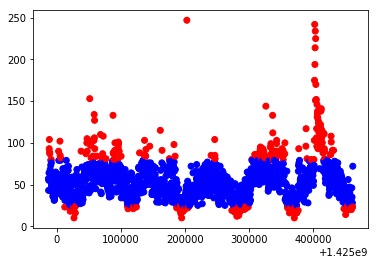

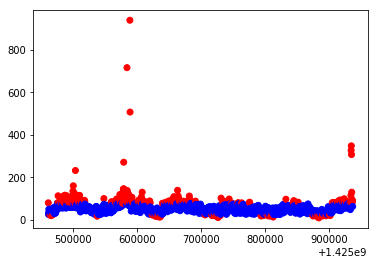

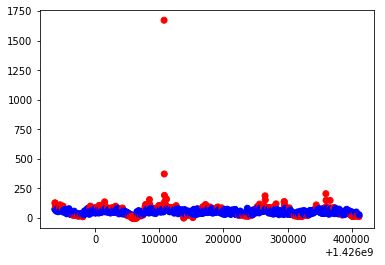

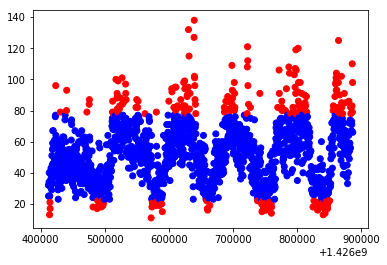

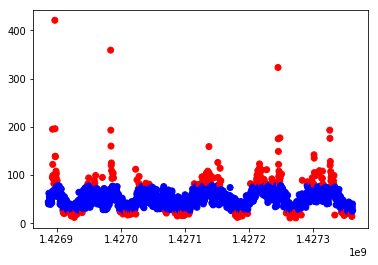

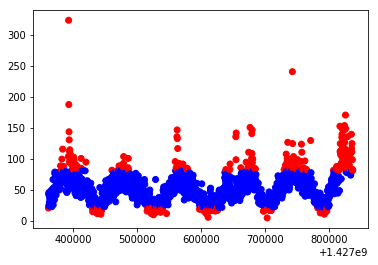

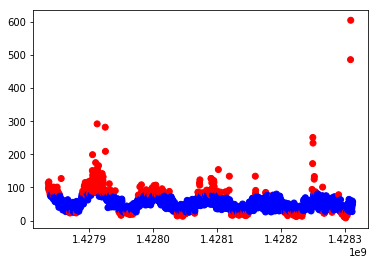

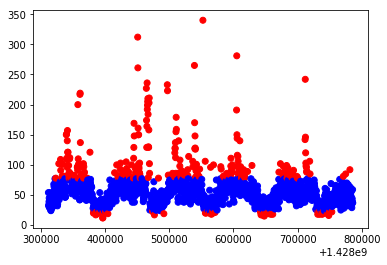

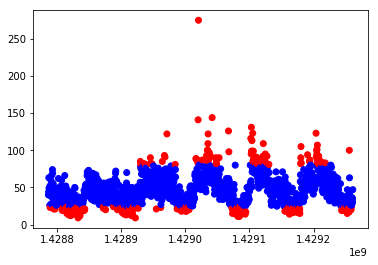

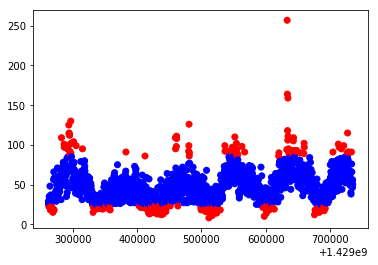

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

kf = KFold(n_splits=10)

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    ds_train, ds_test = ds[train_idx], ds[test_idx]

    model = IsolationForest(contamination="auto", behaviour="new")

    model.fit(X_train)

    Y = model.predict(X_test)

    C = np.array(list(map(lambda x: "red" if x == -1 else "blue", Y)))

    plt.scatter(ds_test, X_test, c=C)
    plt.show()



### DBSCAN

Next, I used DBSCAN. For this, whenever DBSCAN said an element was outside of a cluster I called that an anomaly. The epsilon value here was choosen by trail and error, but it also makes sense due to the tight packing of most of the datapoints.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)

X_norm = scaler.transform(X)

/home/grant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


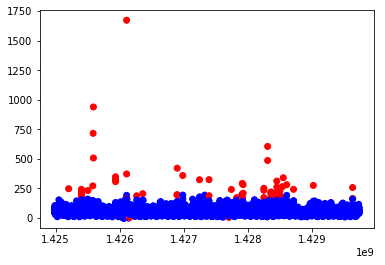

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

model = DBSCAN(eps=0.001)

Y = model.fit_predict(X_norm)

C = np.array(list(map(lambda x: "red" if x == -1 else "blue", Y)))

plt.scatter(ds, X, c=C)
plt.show()

### One Class Support Vector Machine

Finally, I used a One Class SVM. The results were interesting in that it seems to be readily mixing points along the average.

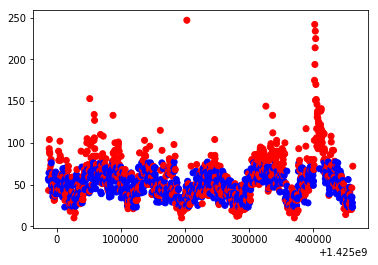

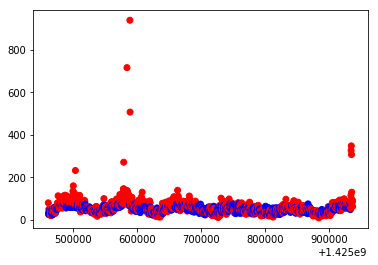

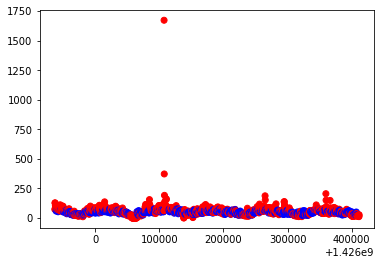

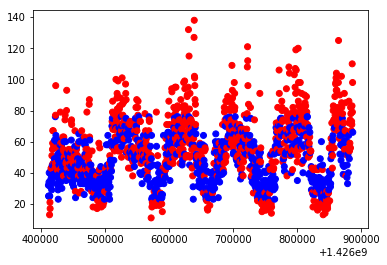

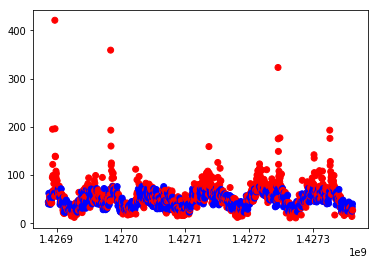

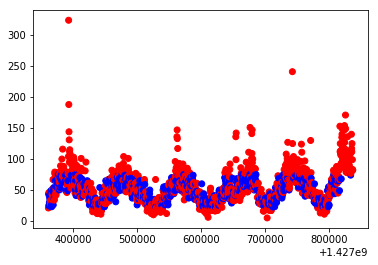

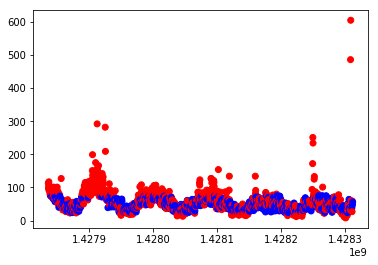

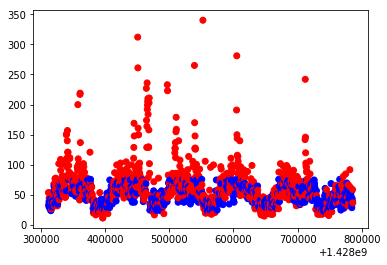

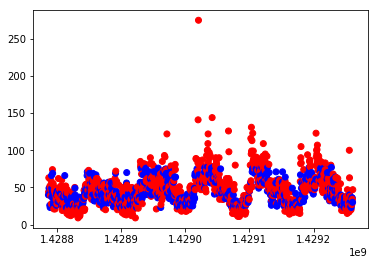

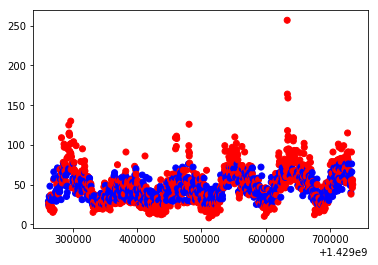

In [10]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

kf = KFold(n_splits=10)

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    ds_train, ds_test = ds[train_idx], ds[test_idx]

    model = OneClassSVM(gamma='scale')

    model.fit(X_train)

    Y = model.predict(X_test)

    C = np.array(list(map(lambda x: "red" if x == -1 else "blue", Y)))

    plt.scatter(ds_test, X_test, c=C)
    plt.show()

## Datetime Modeling

Next, in a timeseries like manner, I converted all the different time fields into their own features and then scaled the values to make them better for use with models. The interesting issue I ran into here is that due to the dependence on the datetime features, when we get observations outside of the training interval the model considers them anomalous even though, to me, they seem like normal values.

In [11]:
minute = twitter_amazon.apply(lambda row: row['time'].minute, axis=1)
hour = twitter_amazon.apply(lambda row: row['time'].hour, axis=1)
weekday = twitter_amazon.apply(lambda row: row['time'].weekday(), axis=1)
month = twitter_amazon.apply(lambda row: row['time'].month, axis=1)
year = twitter_amazon.apply(lambda row: row['time'].year, axis=1)

X = np.append(X, np.array(minute).reshape(-1, 1), 1)
X = np.append(X, np.array(hour).reshape(-1, 1), 1)
X = np.append(X, np.array(weekday).reshape(-1, 1), 1)
X = np.append(X, np.array(month).reshape(-1, 1), 1)
X = np.append(X, np.array(year).reshape(-1, 1), 1)

In [12]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

/home/grant/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Isolation Forest

Again, I first used Isolation Forest. As I talked about above, we have this weird, but logical issue where it's considering values from times that we didn't train on anomalous.

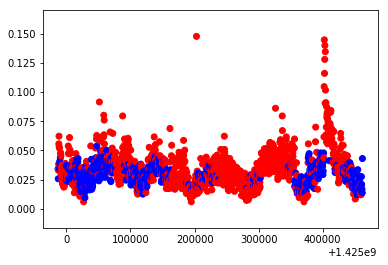

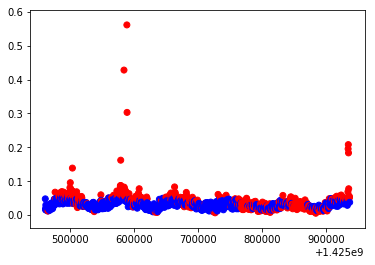

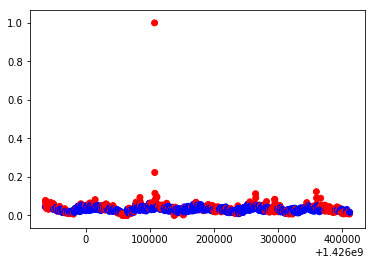

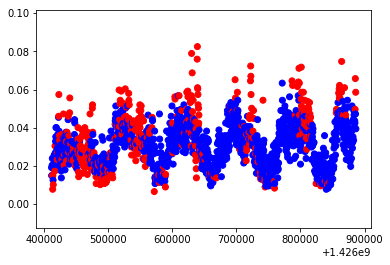

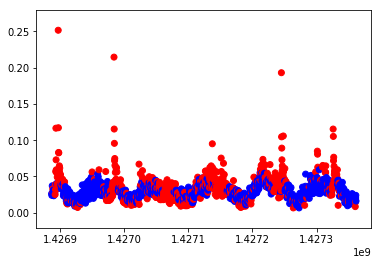

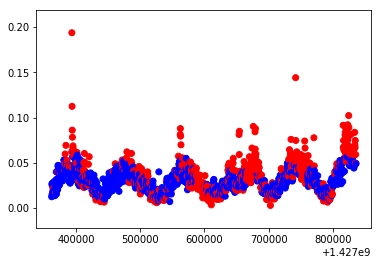

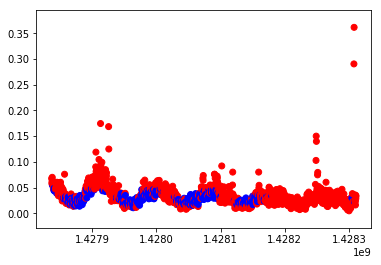

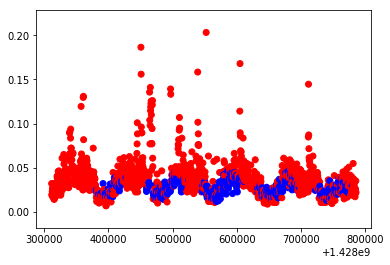

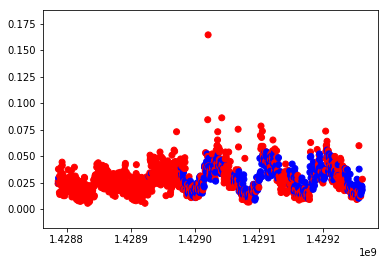

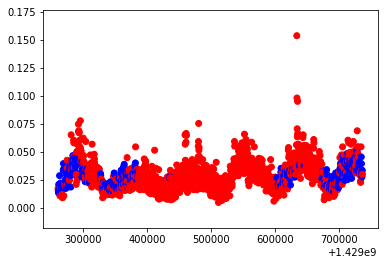

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

kf = KFold(n_splits=10)

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    ds_train, ds_test = ds[train_idx], ds[test_idx]

    model = IsolationForest(contamination="auto", behaviour="new")

    model.fit(X_train)

    Y = model.predict(X_test)

    C = np.array(list(map(lambda x: "red" if x == -1 else "blue", Y)))

    plt.scatter(ds_test, X_test[:,0], c=C)
    plt.show()

### DBSCAN

I next used DBSCAN again with the same method as before. It seems pretty simmmilar to the previous DBSCAN model though with a few more observations detected as anomalies.

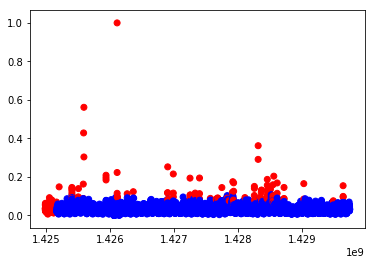

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

model = DBSCAN(eps=0.045)

Y = model.fit_predict(X)

C = np.array(list(map(lambda x: "red" if x == -1 else "blue", Y)))

plt.scatter(ds, X[:,0], c=C)
plt.show()

### One Class Support Vector Machine

Finally, I used an One Class SVM. As with Isolation Forest, we have this issue with datetimes that we're encountered during training.

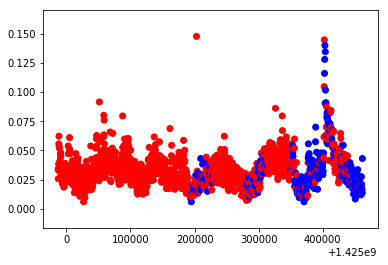

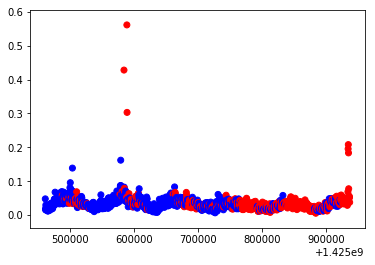

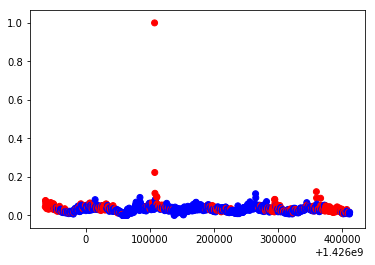

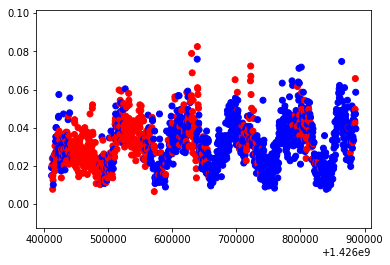

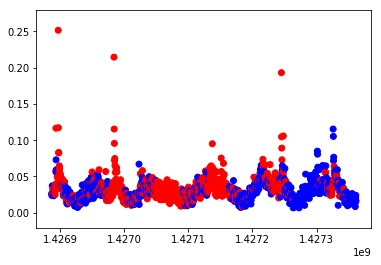

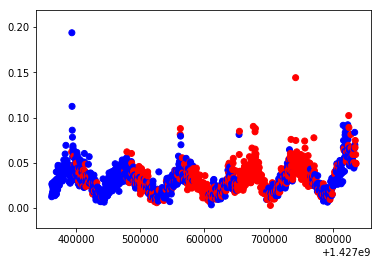

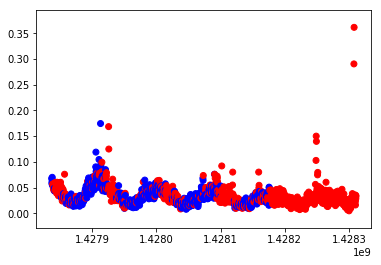

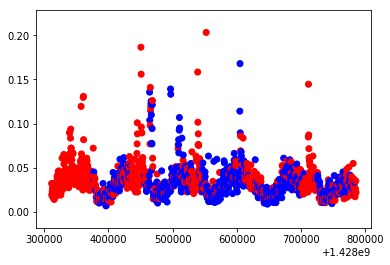

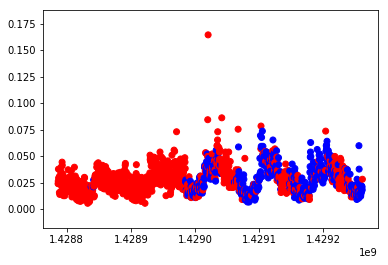

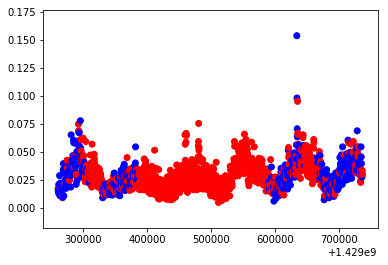

In [15]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

kf = KFold(n_splits=10)

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    ds_train, ds_test = ds[train_idx], ds[test_idx]

    model = OneClassSVM(gamma='scale')

    model.fit(X_train)

    Y = model.predict(X_test)

    C = np.array(list(map(lambda x: "red" if x == -1 else "blue", Y)))

    plt.scatter(ds_test, X_test[:,0], c=C)
    plt.show()

## Final Thoughts

I got some interesting and I think decent results. I think the One Class SVM is promising, I just need to figure out how to better work with times that were outside of training so that we can use it with more features than just the count value. 